# JEM Forms(json_metadata.csv: mouse & human data)

### Data Output: Date, Layer, Cell Type Prediction (Human), Patch Duration(min), post_patch

In [1]:
#json_metadata.csv created on 6/14/2018
#shiny_mouse.csv created on 6/07/2018, updated on 6/06/2018
#shiny_human.csv created on 6/07/2018, updated on 6/06/2018

In [2]:
import csv
import json
import numpy as np
import pandas as pd
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import JEM_post_patch as pp #post patch script
#post_patch_column = 'extraction.postPatch'
#post_patch_pipette_column = 'extraction.endPipetteR'

In [3]:
pd.options.display.max_columns = None  #Displays all the columns

In [4]:
def get_json_df():    
    json_df = pd.read_csv('C:/users/ramr/documents/github/coding/personal-projects/csv/json_metadata.csv')
    json_df = json_df[json_df['status'] == 'SUCCESS']

    #Creates patch_duration column and outputs in minutes
    json_df['patch_duration'] = pd.to_datetime(json_df['extraction.timeRetractionEnd']) - pd.to_datetime(json_df['recording.timeWholeCellStart'])
    json_df['patch_duration'] = (json_df['patch_duration'].astype('timedelta64[s]'))/60

    json_df['date'] = json_df['date'].str[:10] #Strip away the time
    json_df['date'] = pd.to_datetime(json_df['date']) #Converting to YYYY-MM-DD
    json_df.set_index('date', inplace = True)

    json_df = pp.postpatch_reclass(json_df) #Makes post patch column with the script
    json_df.sort_index(inplace = True) #Sort the date column just in case

    #ROI major and minor better to use than approach.manualROI
    json_df = json_df[[#'organism_name', #Optional
                       #'name', #Optional
                       #'approach.manualRoi',
                       'roi_major',
                       'roi_minor',
                       'recording.humanCellTypePrediction',
                       'patch_duration',
                       'post_patch',
                       'extraction.tubeID']]
    #Human data starts around 12/05/17 but there should be some before it(Another problem?)
    return json_df

In [5]:
def get_shiny_df():
    shiny_human_df = pd.read_csv("C:/users/ramr/documents/github/coding/personal-projects/csv/shiny_human.csv")
    shiny_mouse_df = pd.read_csv("C:/users/ramr/documents/github/coding/personal-projects/csv/shiny_mouse.csv")
    
    frames = (shiny_human_df, shiny_mouse_df)
    shiny_df = pd.concat(frames)
    shiny_df = shiny_df.loc[:,['sample_id', 'res_index_label', 'cluster_label']]
    return shiny_df

In [6]:
def merge_dfs(df1, df2):
    merged_df = pd.merge(left = df1, 
                         right = df2, 
                         left_on = 'extraction.tubeID', #json
                         right_on = 'sample_id', #shiny
                         how = 'inner')
    merged_df.drop(['sample_id'], axis = 1, inplace = True)
    return merged_df

In [7]:
def pie_plot(df):
    plt.figure(3)
    df1 = df.loc[:,['post_patch', 'extraction.tubeID']]
    df1 = df1.groupby('post_patch').count()
    df1 = df1.rename(columns = {'extraction.tubeID' : 'count'})
    df1 = df1.pivot_table(values=['count'], index=['post_patch'], aggfunc='sum')
    df1.plot.pie(y= 'count', autopct='%1.1f%%', figsize = (9,8), 
                 colors = ['#f7fcb9', '#fc9272', '#de2d26', '#31a354', '#a1d99b']) 
    #Entire(Yellow), No_high(Light Red), No_low(Red), Nuc_high(Green), Nuc_low(Light Green)
    
    #df['post_patch'].value_counts().plot(kind = 'pie', autopct='%1.1f%%', figsize = (9,9))

In [8]:
#Making global variables
json_df = get_json_df()
shiny_df = get_shiny_df()
merged_df = merge_dfs(json_df, shiny_df)

C:\Users\ramr\AppData\Local\Continuum\anaconda2\lib\site-packages\pandas\core\indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\ramr\AppData\Local\Continuum\anaconda2\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\ramr\AppData\Local\Continuum\anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2822: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False

In [9]:
merged_df.head()

,roi_major,roi_minor,recording.humanCellTypePrediction,patch_duration,post_patch,extraction.tubeID,res_index_label,cluster_label
0,VISp,layer 5,NaN,9.483333,Nuc-high seal,P8S4_171002_354_A01,1.000000,Vip Lmo1 Fam159b
1,VISp,layer 2/3,NaN,6.416667,No-high seal,P9S4_171002_403_A01,0.291080,n4
2,VISp,layer 2/3,NaN,5.416667,No-low seal,P9S4_171002_405_A01,0.000000,n3
3,VISp,layer 6a,NaN,7.616667,No-low seal,P9S4_171002_406_A01,0.291080,n4
4,VISp,layer 5,NaN,13.766667,No-low seal,P8S4_171002_357_A01,0.580975,n89


In [10]:
merged_df.tail()

,roi_major,roi_minor,recording.humanCellTypePrediction,patch_duration,post_patch,extraction.tubeID,res_index_label,cluster_label
3040,VISp,layer 5,NaN,9.650000,Nuc-high seal,P8S4_180605_352_A01,1.0000,Sst Hpse Cbln4
3041,VISp,layer 2/3,NaN,10.650000,Nuc-high seal,P8S4_180605_353_A01,0.8441,n108
3042,VISp,layer 6a,NaN,7.000000,Nuc-high seal,P9S4_180605_404_A01,1.0000,Sst Rxfp1 Prdm8
3043,VISp,layer 5,NaN,9.816667,Nuc-high seal,P8S4_180605_354_A01,1.0000,Sst Nr2f2 Necab1
3044,VISp,layer 2/3,NaN,7.966667,Nuc-high seal,P8S4_180605_355_A01,1.0000,L2/3 IT VISp Agmat


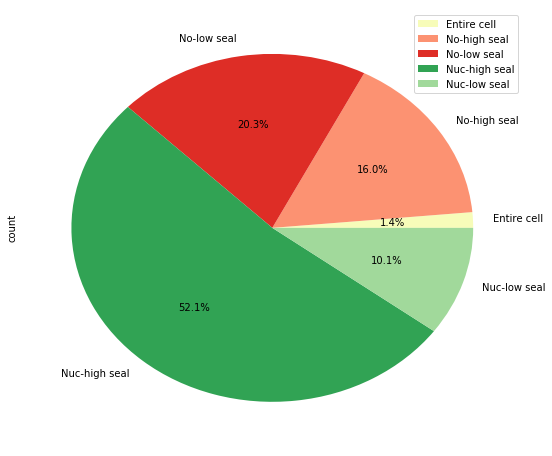

In [11]:
pie_plot(merged_df)